# Density vs density-contrast

In [ ]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# local python scripts
import harmonica as hm
import numpy as np
import pygmt
import verde as vd
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
rock_prism = [-134, -5, -45, 45, -200, -100]
ice_prism = [-134, -5, -45, 45, -100, 0]
coordinates = [-40, 0, 40]

In [4]:
ice_grav = hm.prism_gravity(coordinates, ice_prism, [917], field="g_z")
ice_grav

array(0.7032679)

In [5]:
rock_grav = hm.prism_gravity(coordinates, rock_prism, [2670], field="g_z")
rock_grav

array(0.54319071)

In [6]:
ice_grav + rock_grav

np.float64(1.246458609712208)

In [7]:
combined = hm.prism_gravity(
    coordinates, [ice_prism, rock_prism], [917, 2670], field="g_z"
)
combined

array(1.24645861)

In [8]:
ice_contrast = hm.prism_gravity(coordinates, ice_prism, [917 - 2670], field="g_z")
ice_contrast

array(-1.34441507)

In [9]:
ice_contrast = hm.prism_gravity(coordinates, ice_prism, [2670 - 917], field="g_z")
ice_contrast

array(1.34441507)

In [10]:
rock_contrast = hm.prism_gravity(coordinates, rock_prism, [2670 - 917], field="g_z")
rock_contrast

array(0.3566342)

In [11]:
rock_contrast = hm.prism_gravity(coordinates, rock_prism, [917 - 2670], field="g_z")
rock_contrast

array(-0.3566342)

In [13]:
import ensaio
import harmonica as hm
import pyproj

# Read Earth's topography grid
fname = ensaio.fetch_earth_topography(version=1)
topography = xr.load_dataset(fname)

# Crop the topography limited to South Africa
region = (12, 33, -35, -18)
region_padded = vd.pad_region(region, pad=5)  # pad the original region
topography = topography.sel(
    longitude=slice(*region_padded[:2]),
    latitude=slice(*region_padded[2:]),
)

# Project the grid
projection = pyproj.Proj(proj="merc", lat_ts=topography.latitude.values.mean())
south_africa_topo = vd.project_grid(topography.topography, projection=projection)

print("Min:", np.nanmin(south_africa_topo))
print("Max:", np.nanmax(south_africa_topo))

Min: -5792.758196352647
Max: 2973.5293403397727


In [14]:
# Create layer of water prisms above topography
water_prisms = hm.prism_layer(
    (south_africa_topo.easting, south_africa_topo.northing),
    surface=south_africa_topo,
    reference=np.nanmax(south_africa_topo),
    properties={"density": 1030 * np.ones_like(south_africa_topo)},
)

# Create layer of earth prisms below topography
earth_prisms = hm.prism_layer(
    (south_africa_topo.easting, south_africa_topo.northing),
    surface=south_africa_topo,
    reference=np.nanmin(south_africa_topo),
    properties={"density": 2670 * np.ones_like(south_africa_topo)},
)

# Create layer of prisms representing the density contrast
zref = np.nanmean(south_africa_topo)

density_contrast_prisms = hm.prism_layer(
    (south_africa_topo.easting, south_africa_topo.northing),
    surface=south_africa_topo,
    reference=zref,
    properties={
        "density": xr.where(
            south_africa_topo >= zref,
            2670 - 1030,
            1030 - 2670,
        )
    },
)

# Compute gravity field on a regular grid located at 4000m above the ellipsoid
coordinates = vd.grid_coordinates(
    region=(12, 33, -35, -18), spacing=0.2, extra_coords=4000
)
easting, northing = projection(*coordinates[:2])
coordinates_projected = (easting, northing, coordinates[-1])

water_prisms_gravity = water_prisms.prism_layer.gravity(
    coordinates_projected, field="g_z"
)
earth_prisms_gravity = earth_prisms.prism_layer.gravity(
    coordinates_projected, field="g_z"
)
density_contrast_gravity = density_contrast_prisms.prism_layer.gravity(
    coordinates_projected, field="g_z"
)

In [15]:
# turn into xarray dataarrays
water_grav_grid = vd.make_xarray_grid(
    coordinates_projected,
    water_prisms_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

earth_grav_grid = vd.make_xarray_grid(
    coordinates_projected,
    earth_prisms_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

density_contrast_grav_grid = vd.make_xarray_grid(
    coordinates_projected,
    density_contrast_gravity,
    data_names="gravity",
    extra_coords_names="extra",
)

# Combine computed gravity
total_gravity = water_grav_grid + earth_grav_grid

In [16]:
# Set figure properties
xy_region = vd.get_region((easting, northing))
w, e, s, n = xy_region
fig_height = 10
fig_width = fig_height * (e - w) / (n - s)
fig_ratio = (n - s) / (fig_height / 100)
fig_proj = f"x1:{fig_ratio}"

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/pygmt/clib/session.py:1498: RuntimeWarning: Grid may have irregular spacing in the 'northing' dimension, but GMT only supports regular spacing. Calculated regular spacing 22283.15174176384 is assumed in the 'northing' dimension.
  matrix, region, inc = dataarray_to_matrix(grid)


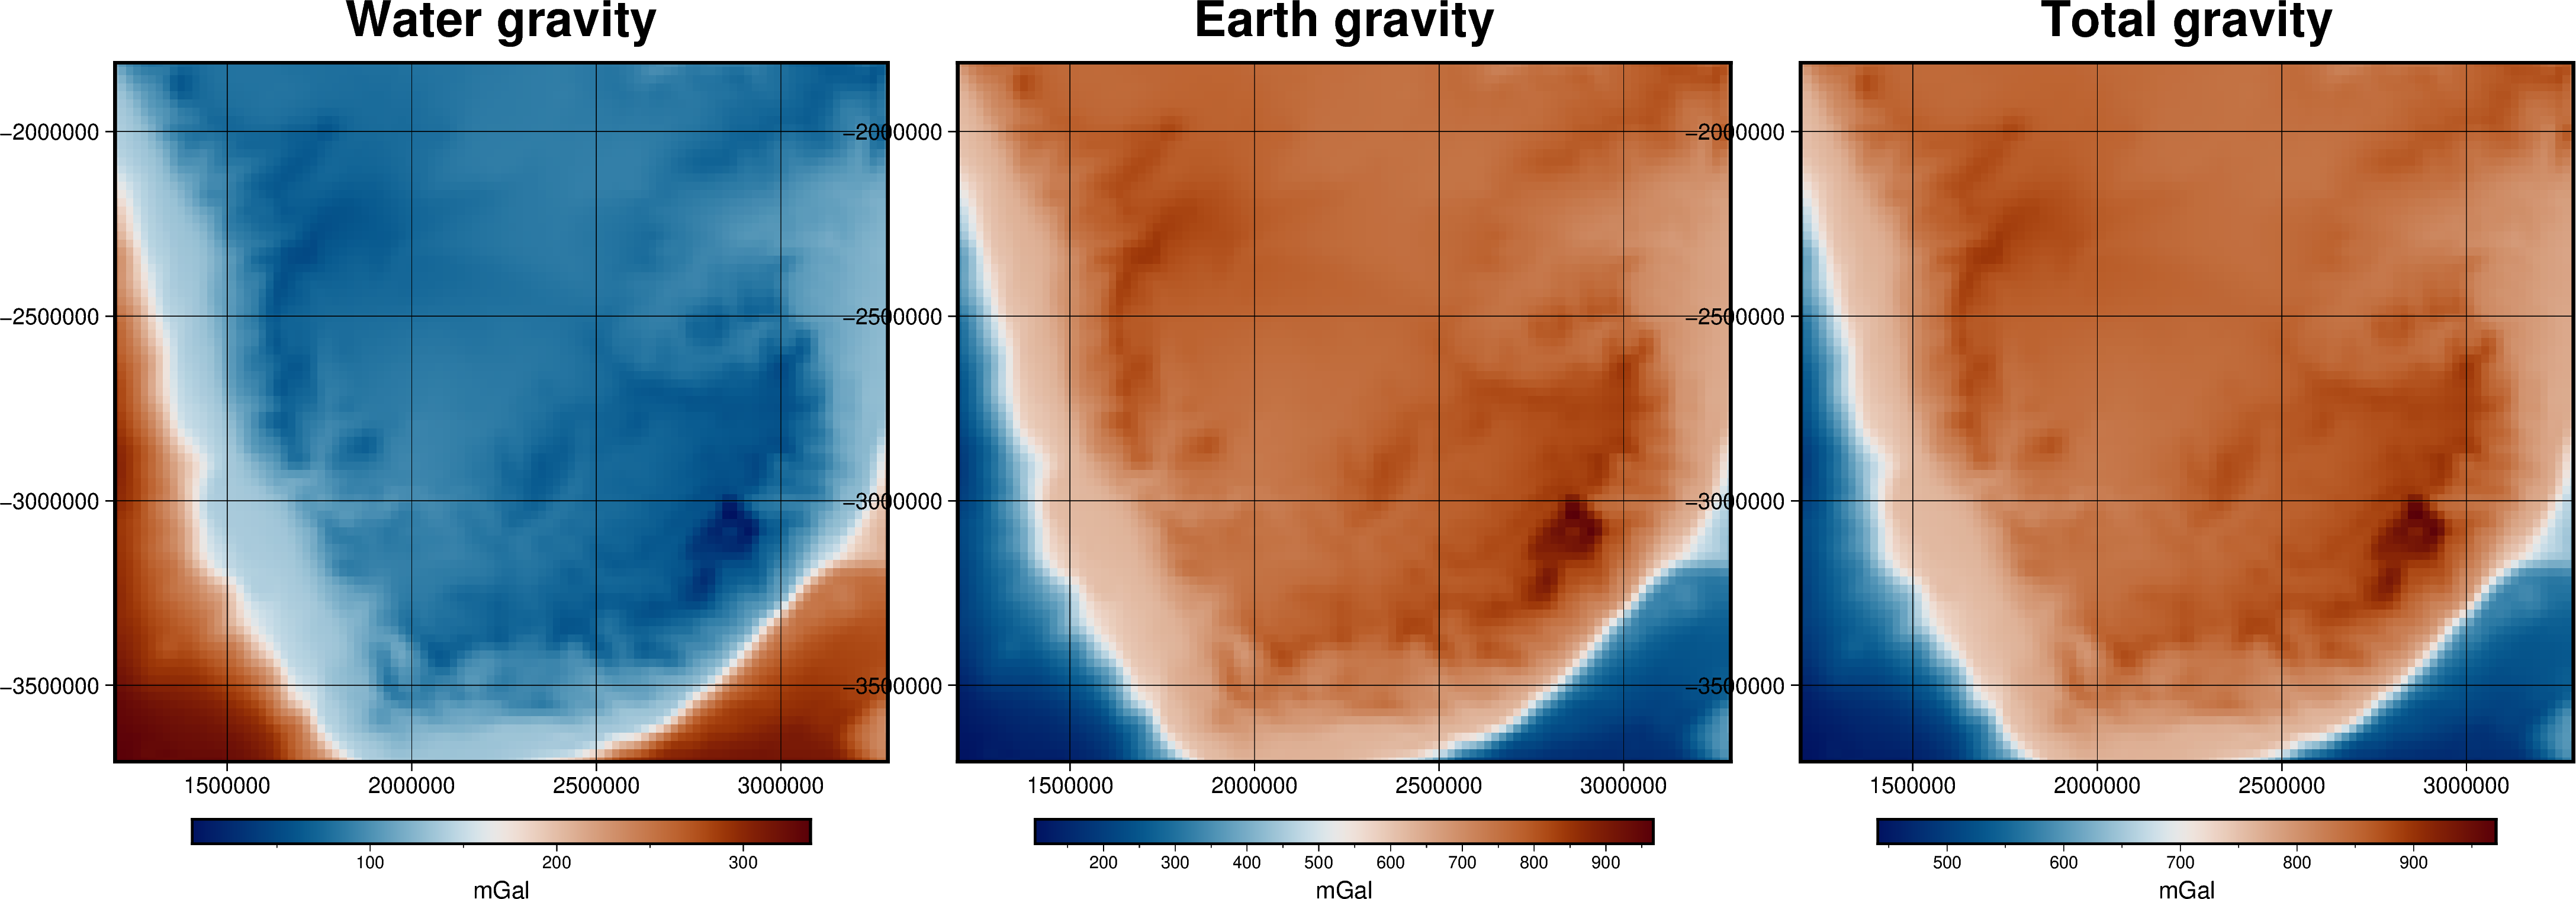

In [17]:
# plot of absolute density gravity
fig = pygmt.Figure()

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=water_grav_grid.gravity,
    frame=["ag", "+tWater gravity"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=earth_grav_grid.gravity,
    frame=["ag", "+tEarth gravity"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=total_gravity.gravity,
    frame=["ag", "+tTotal gravity"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.show()

/home/mdtanker/miniforge3/envs/RIS_gravity_inversion/lib/python3.11/site-packages/pygmt/clib/session.py:1498: RuntimeWarning: Grid may have irregular spacing in the 'northing' dimension, but GMT only supports regular spacing. Calculated regular spacing 22283.15174176384 is assumed in the 'northing' dimension.
  matrix, region, inc = dataarray_to_matrix(grid)


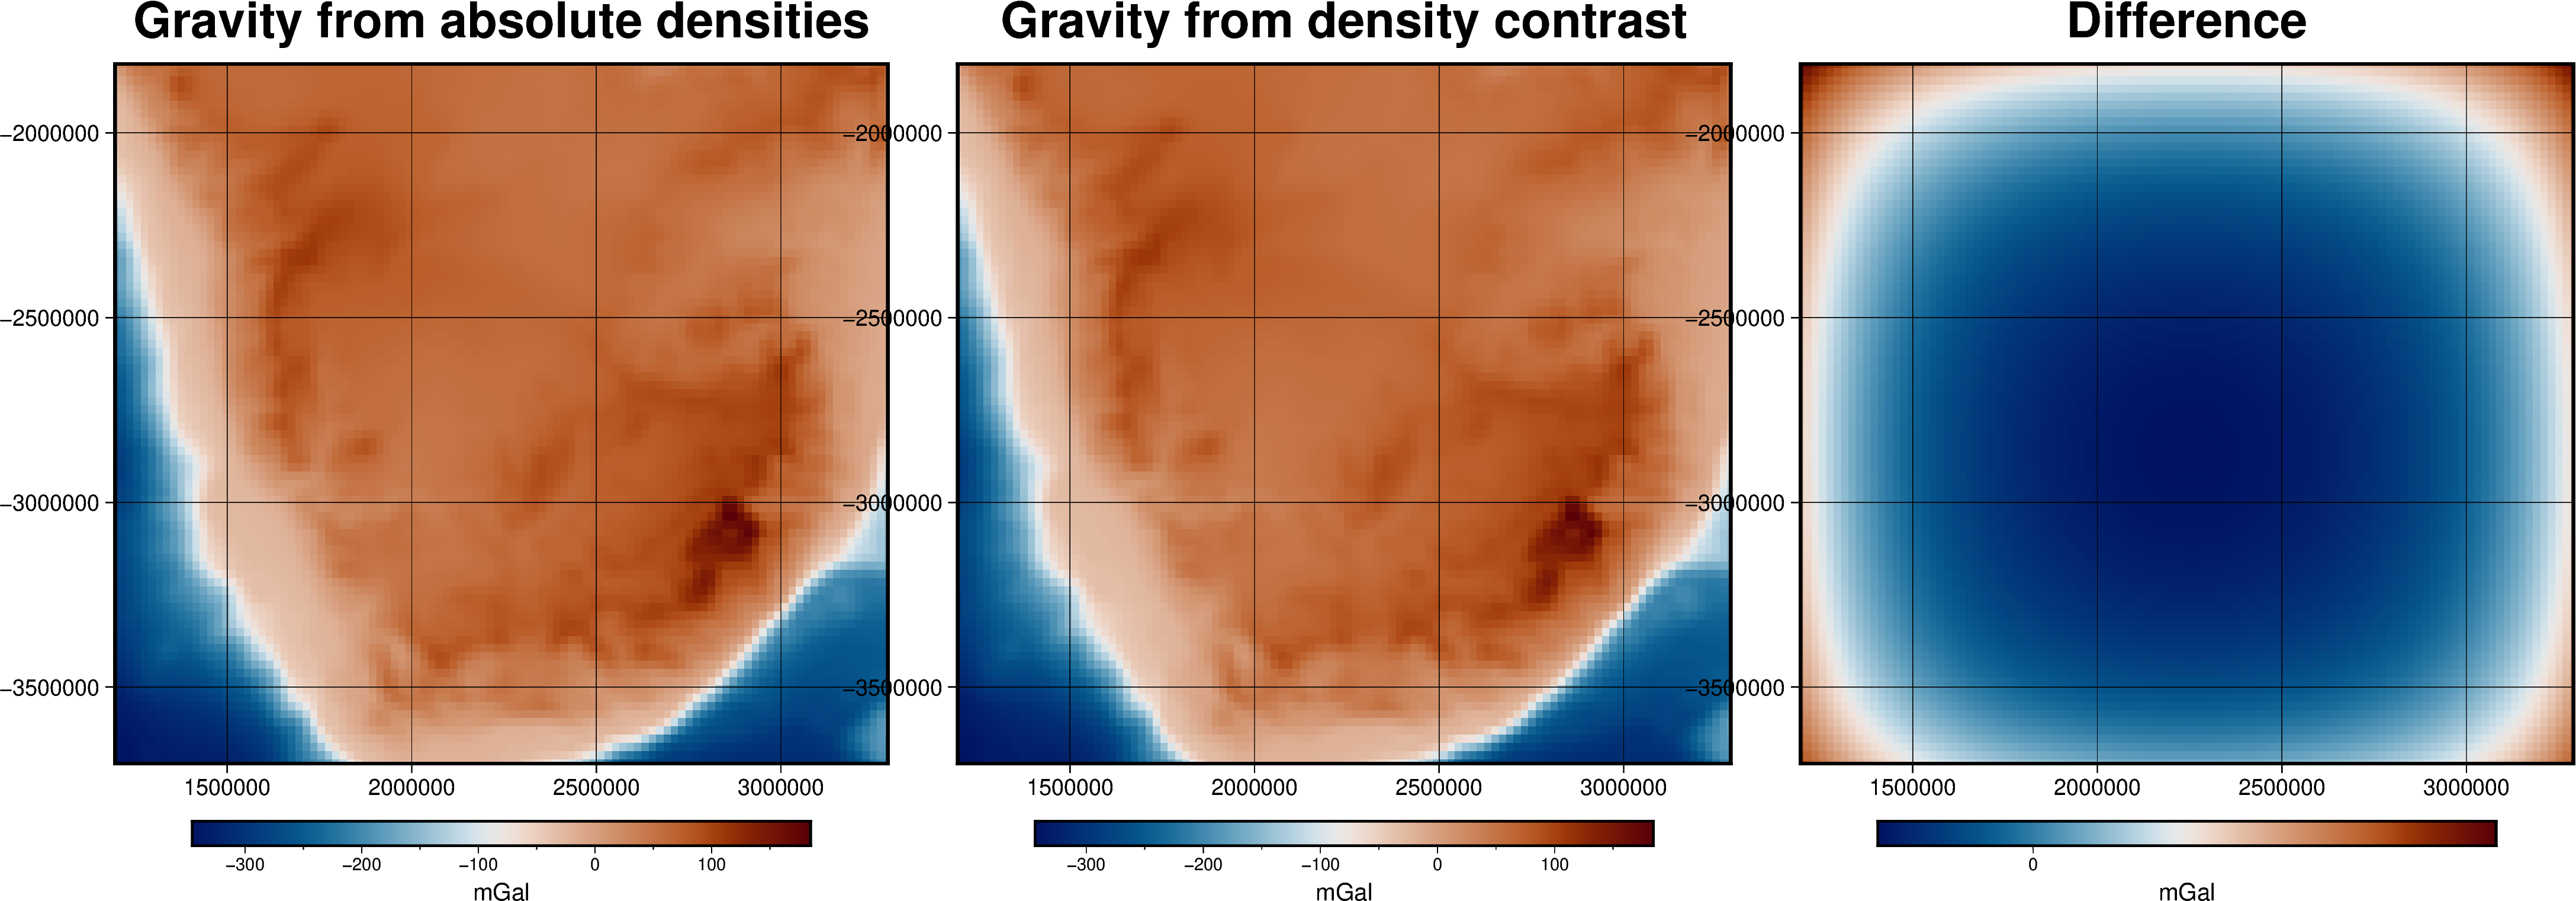

In [18]:
# Center grids on 0
total_gravity -= total_gravity.mean()
density_contrast_grav_grid -= density_contrast_grav_grid.mean()

fig = pygmt.Figure()

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=total_gravity.gravity,
    frame=["ag", "+tGravity from absolute densities"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=density_contrast_grav_grid.gravity,
    frame=["ag", "+tGravity from density contrast"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.shift_origin(xshift=fig_width + 1)

fig.grdimage(
    region=xy_region,
    projection=fig_proj,
    grid=(density_contrast_grav_grid.gravity - total_gravity.gravity),
    frame=["ag", "+tDifference"],
    cmap="vik",
)
fig.colorbar(cmap=True, frame=["a100f50", "x+lmGal"])

fig.show()

(array([267., 259., 257., 249., 244., 235., 227., 232., 219., 210., 211.,
        212., 197., 202., 185., 191., 180., 168., 199., 175., 155., 179.,
        150., 162., 159., 151., 156., 145., 148., 131., 146., 138., 138.,
        130., 133., 105., 131., 112.,  96., 121.,  97.,  85., 118.,  91.,
         65., 121.,  81.,  75.,  99.,  86.,  74.,  64.,  99.,  76.,  67.,
         61.,  66.,  50.,  50.,  42.,  38.,  35.,  32.,  31.,  26.,  23.,
         24.,  19.,  26.,  14.,  19.,  16.,  11.,  16.,  11.,  11.,  10.,
          9.,  10.,   8.,   4.,   8.,   4.,   5.,   5.,   4.,   2.,   5.,
          2.,   2.,   5.,   0.,   0.,   5.,   0.,   0.,   2.,   1.,   0.,
          1.]),
 array([-0.65858844, -0.63238491, -0.60618138, -0.57997785, -0.55377432,
        -0.52757079, -0.50136726, -0.47516373, -0.4489602 , -0.42275668,
        -0.39655315, -0.37034962, -0.34414609, -0.31794256, -0.29173903,
        -0.2655355 , -0.23933197, -0.21312844, -0.18692491, -0.16072138,
        -0.13451785, -0.10

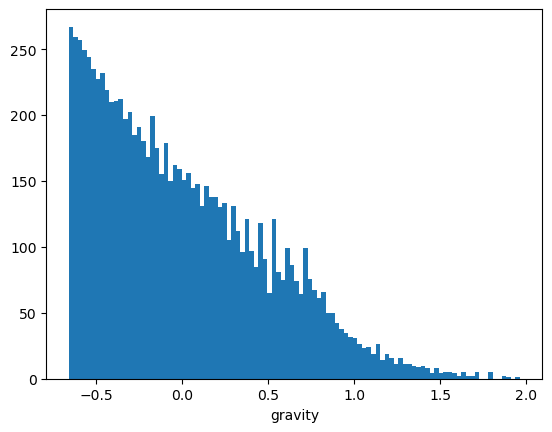

In [19]:
(density_contrast_grav_grid.gravity - total_gravity.gravity).plot.hist(bins=100)